In [16]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm  # Import tqdm for progress visualization

from numba import njit

import sys

import copy

import numpy as np
import scipy as scy
import math as math

from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

In [17]:
class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, n_Particles:int, boundary:bool, rng_seed:int|None=None):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
        n_Particles : an integer of the number of Particles in the box. Needed to initialize all arrays correctly.\n
        boundary    : Wether the box_borders are hard boundaries.\n
        rng_seed    : Random Number Generator seed for reproducible results. None for random seed.
        """
        # constants
        self.c_6        = 6.2647225     # kg/mol  *  nm**8/ns**2
        self.c_12       = 9.847044e-3   # kg/mol  *  nm**14/ns**2
        self.kB         = 1.380e-23     # J/K
        self.avogadro   = 6.022e23      # 1/mol

        self.box_size       = box_size
        # Particles statistics are no longer stored in a separate class but in arrays, which allows for easier calculations
        self.particles_pos  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)
        self.particles_vel  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)
        self.particles_acc  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)

        # All of the radii stored in an array
        # Additionally the combined raddii are calculated for each pair
        self.particles_r    = np.zeros(n_Particles, dtype=float)
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:] # shape (n,n)

        # All of the masses are stored in an array
        self.particles_m    = np.zeros(n_Particles, dtype=float)
        
        # We use distance matrices for true distances (distances_mat) in x and y coords, 
        # distances with ghost particles for cross boundary calculations (distance_ghost) in x and y coords
        # and the norm of the ghost_distances as a single float
        self.distance_mat   = np.zeros((n_Particles,n_Particles,2), dtype=float)
        self.distance_ghost = np.zeros((n_Particles,n_Particles,2), dtype=float)
        self.distance_abs   = np.zeros((n_Particles,n_Particles), dtype=float)
        self.distance_abs_ghost   = np.zeros((n_Particles,n_Particles), dtype=float)
        # A vectorial force matrix to store the forces between each pair of particles in both directions
        self.force_mat      = np.zeros((n_Particles,n_Particles,2), dtype=float)
        # Storing the energy types currently in the system
        self.potEnergy_mat  = np.zeros((n_Particles,n_Particles), dtype=float)
        self.kinEnergy_mat  = np.zeros((n_Particles), dtype=float)

        # The  current temperatur of the entire system
        self.temp:float = 0. # K
        # The number of particles as an int
        self.n_particles:int = n_Particles
        # Wether a boundary at the edge of the box exists:
        self.boundary = boundary

        # Random Number Generator used with seed
        self.rng = np.random.default_rng(seed=rng_seed)


    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")



    def random_positions(self, axis, n_particles = 0) -> None:
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fixedtemp_velocities(self, target_temp):
        """Calculate initial velocities, so that the initial kinetic energy corresponds to a target temperature"""
        self.temp = target_temp
        kin_energy = self.kB * target_temp
        velocities = np.sqrt(2 * (kin_energy/self.n_particles) / (self.particles_m / self.avogadro))
        return velocities

    def fill_particles(self, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2), target_temp:float = 300) -> None:
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius\n
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity\n
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed\n
        x,y         : initial positions as array of length n; default random positions 0.5 away from border; Only used when align = 'defined'\n
        align       : Type of Particle placement: random = random positions; grid = grid-like arrangement(needs corresponding grid argument); defined = as given by x,y input\n
        grid        : 2x2 array that defines how many Particles should be in the grid on the x- and y- axis. Take care of correct number of particles!
        """
        # filling radius and mass, if given as a number for all particles
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:]
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass
            
        # randomize the angles if not given
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
        # fill velocities if given as a number for all particles
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        elif type(vel) == str:
            vel = self.fixedtemp_velocities(target_temp)
        
        # calculate the coressponding velocities
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel

        """
        Check which alignment method should be choosen and fill the positions accoringly
        """
        if align == 'random':
            self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            self.particles_pos[:,1] = self.random_positions(1,self.n_particles)
        elif align == 'grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally the entire grid is moved by 0.01 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                max_rad = np.max(self.particles_r)+0.01
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]-max_rad,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1]-max_rad,num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + max_rad # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'left-grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally, the entire grid is moved by 0.1 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                max_rad = np.max(self.particles_r)+0.01
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]/2-max_rad,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1]-max_rad,num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + max_rad # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'defined':
            self.particles_pos[:,0] = x
            self.particles_pos[:,1] = y
        

    def move(self, dt:float = 1.0, vel = [], particles = []) -> None:
        """moving the particle in the direction, where the velocity-vector points.\n
        dt          : the time-step moving forward; default = 1\n
        vel         : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        particles   : The particles that should be moved as indices for the position array of this class; default(empty) = all particles
        """
        if len(particles) == 0:
            if len(vel) == 0:
                vel = self.particles_vel
            self.particles_pos += vel*dt
        else:
            if len(vel) == 0:
                vel = self.particles_vel[particles]
            self.particles_pos[particles] += vel*dt

    def wrap_around(self) -> None:
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size


        

    def calculate_distance_matrix(self) -> None:
        """Calculates a matrix, containing x and y distances of all particles to all other particles in both directions.\n
        It is by nature not symmetric, but rather the upper triangle is negated and flipped"""
        self.distance_mat = self.particles_pos[np.newaxis, :, :] - self.particles_pos[:, np.newaxis, :] # shape: (n,n,2)
        # The norm is calculated as well as the absolute distance between each Particle pair. Symmetric by nature
        self.distance_abs = np.linalg.vector_norm(self.distance_mat, axis = 2) # shape: (n,n)
        
        if self.boundary:
            # the ghost matrix is calculated to account for interactions that go over the boundary of the box.
            # This is adjusted, if the x or y distances is greater than half the box size, which makes the distance across boundaries shorter
            self.distance_ghost = np.where(self.distance_mat[:, :] > (0.5 * self.box_size), 
                                        self.distance_mat[:, :] - self.box_size, self.distance_mat[:, :]) # shape: (n,n,2)
            self.distance_ghost = np.where(self.distance_ghost[:, :] < -(0.5 * self.box_size), 
                                        self.distance_ghost[:, :] + self.box_size, self.distance_ghost[:, :]) # shape: (n,n,2)
            
            self.distance_abs_ghost = np.linalg.vector_norm(self.distance_ghost, axis = 2) # shape: (n,n)
        


In [18]:
class Langevin(Box):
    def __init__(self, box_size, n_Particles: int, samples, boundary: bool, rng_seed: int | None = None):
        super().__init__(box_size, n_Particles, boundary, rng_seed)

        self.samples = samples

        self.pos = np.zeros((self.n_particles,2,samples+1))
        self.vel = np.zeros((self.n_particles,2,samples+1))


    
    def langevin(self, gamma, delta_t = 1e-6):
        
        
        self.pos[:,:,0] = self.particles_pos
        self.vel[:,:,0] = self.particles_vel

        # calculate the coressponding velocities
        rand_k = self.rng.normal(0,1,(self.n_particles,2,self.samples))

        for i in tqdm(range(self.samples)):
            self.pos[:,:,i+1] = self.pos[:,:,i] + self.vel[:,:,i]*delta_t
            self.vel[:,:,i+1] = self.vel[:,:,i] - (1/self.particles_m[:,np.newaxis])*(gamma*self.vel[:,:,i]
                                                                                      *delta_t - np.sqrt(2*(gamma*self.avogadro)*
                                                                                                         self.kB*self.temp*delta_t)*rand_k[:,:,i])
        

In [19]:
box_size = np.array([10,10])
grid = np.array([5,10])
n_particles = 1
steps = 100000
time_step = 1e-6

In [20]:
kB = 1.380e-23 # J/K
T = 293.15 #K
gamma = 50 #kg/(mol*ns)
mass = 0.018 #kg/mol
 
avogadro = 6.022e23      # 1/mol

In [21]:
simL = Langevin(box_size=box_size, n_Particles=n_particles, samples=steps, boundary=False, rng_seed=421)

In [22]:
simL.fill_particles(radius=0, mass=0.018, vel='ahsd',align='random', target_temp=T)

In [23]:
simL.langevin(gamma=gamma)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:02<00:00, 43805.79it/s]


Comparison lanevin vs md simulation:
langevin does 36000 iterations/second for 10 particles, while this scales roughly with n steps
md simulation does 2000 iterations/second for 25 particles, also scaling roughly with n steps
However in both cases time is not necessary the limiting factor, but rather the memory consumed by the different arrays. A langevin simulation for 25 particles and 10mil steps takes already more than my 16gb of RAM. With MD simulations we are hitting the wall at around 10000000 steps and 50 particles, so half the time, but double the particles. Whilst having 2.5x amount of particles, MD simulation computes iterations with ~1/18 of the speed.

In [24]:
simL.vel = 0

2min9s

In [25]:
sys.getsizeof(simL.vel)/1e6

2.8e-05

single particle calculation:

149951.37it/s

multiple particle calculation with class implementation:

38377.58it/s

In [26]:
time = np.arange(0,(simL.samples+1)*1e-6,1e-6)


0


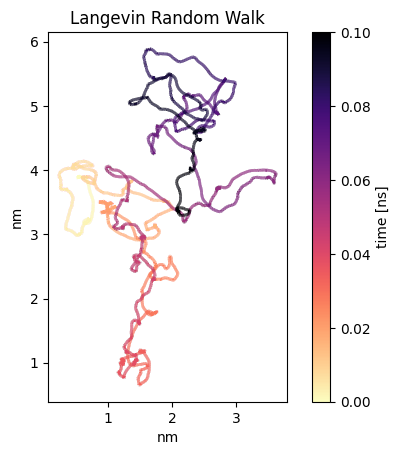

In [27]:
# DO NOT USE WITH MANY PARTICLES. EATS YOUR MEMORY

# Define the age-based colors
norm = Normalize(vmin=0, vmax=time[-1])  # Normalize based on number of points
cmap = plt.cm.magma_r  # Choose a colormap

# Plot using LineCollection
fig, ax = plt.subplots()


for i in range(simL.pos.shape[0]):
    print(i)
    # Create segments for the random walk
    points = simL.pos[i].T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)


    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(time)  # Use indices to colorize
    lc.set_linewidth(2)  # Optional: Adjust line width


    ax.add_collection(lc)


ax.autoscale()  # Adjust plot limits to fit data
ax.set_aspect('equal')

ax.set_xlabel('nm')
ax.set_ylabel('nm')

# Add a colorbar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('time [ns]')

plt.title('Langevin Random Walk')
plt.show()

In [29]:
simL.pos

array([[[0.51121004, 0.51170425, 0.51222502, ..., 2.08581974,
         2.0853798 , 2.08491467],
        [3.87949291, 3.87965551, 3.87981336, ..., 3.34780033,
         3.34786596, 3.34794096]]])

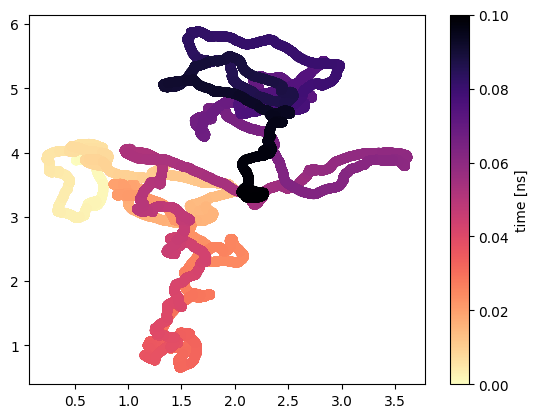

In [34]:
plt.scatter(simL.pos[0,0], simL.pos[0,1],c=time,cmap='magma_r')
# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('time [ns]')

149951.37it/s

122848.82it/s

In [15]:
#plt.scatter(pos[0], pos[1], c=time, cmap = cmap, )

In [16]:
d_r = (simL.pos-simL.pos[:,:,0,np.newaxis])**2/(4*time)

/tmp/ipykernel_5112/3813451101.py:1: RuntimeWarning: invalid value encountered in divide
  d_r = (simL.pos-simL.pos[:,:,0,np.newaxis])**2/(4*time)


In [17]:
d_r.shape

(10, 2, 10000001)

In [18]:
x_mean = np.mean(d_r[:,0], axis=0)
y_mean = np.mean(d_r[:,1], axis=0)

x_std = np.std(d_r[:,0], axis=0)
y_std = np.std(d_r[:,1], axis=0)

colours = ['r','k']

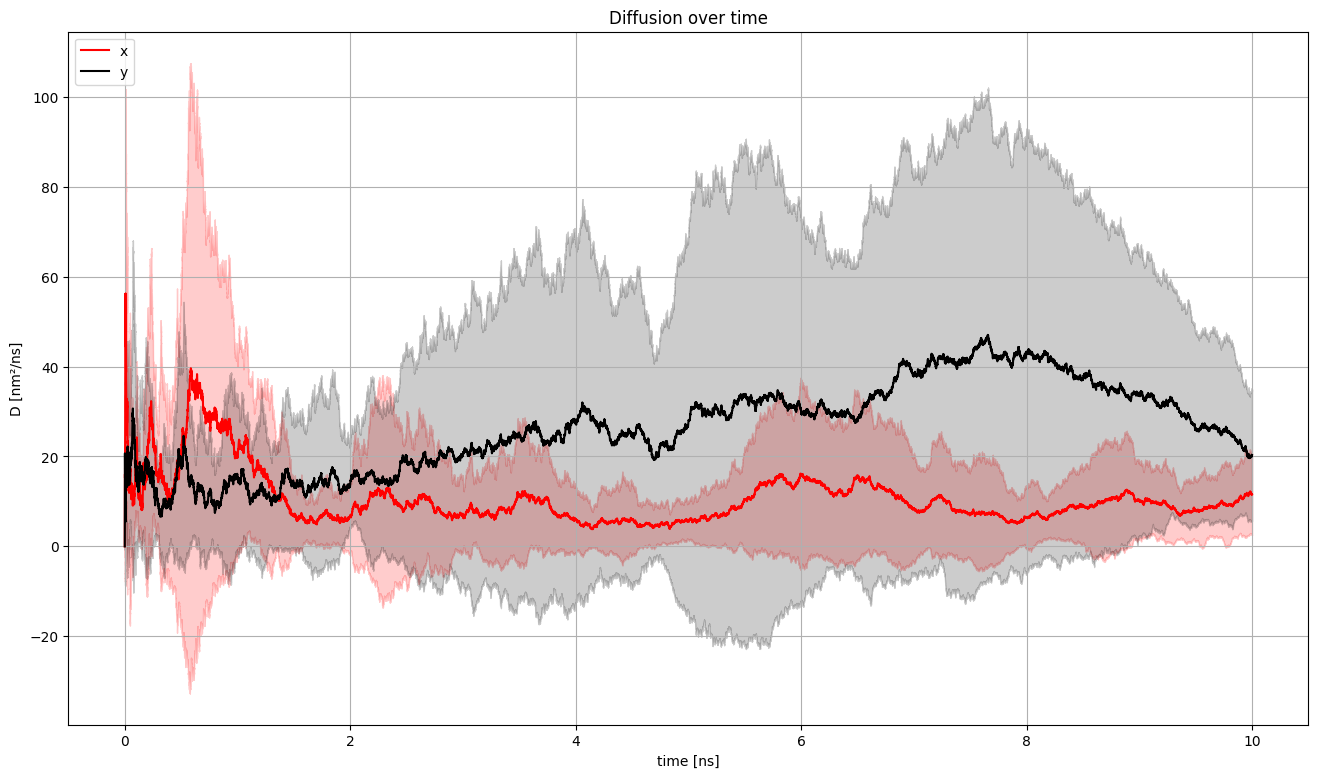

In [19]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(time,x_mean, color = colours[0], label = 'x')
ax.plot(time,y_mean, color = colours[1], label = 'y')

ax.fill_between(time,x_mean - x_std,x_mean + x_std, alpha=0.2, color = colours[0], label = 'std(x)')
ax.fill_between(time,y_mean - y_std,y_mean + y_std, alpha=0.2, color = colours[1], label = 'std(y)')

ax.set_xlabel('time [ns]')
ax.set_ylabel('D [nm²/ns]')
plt.title('Diffusion over time')
plt.grid()
plt.legend(loc='upper left')
plt.show()

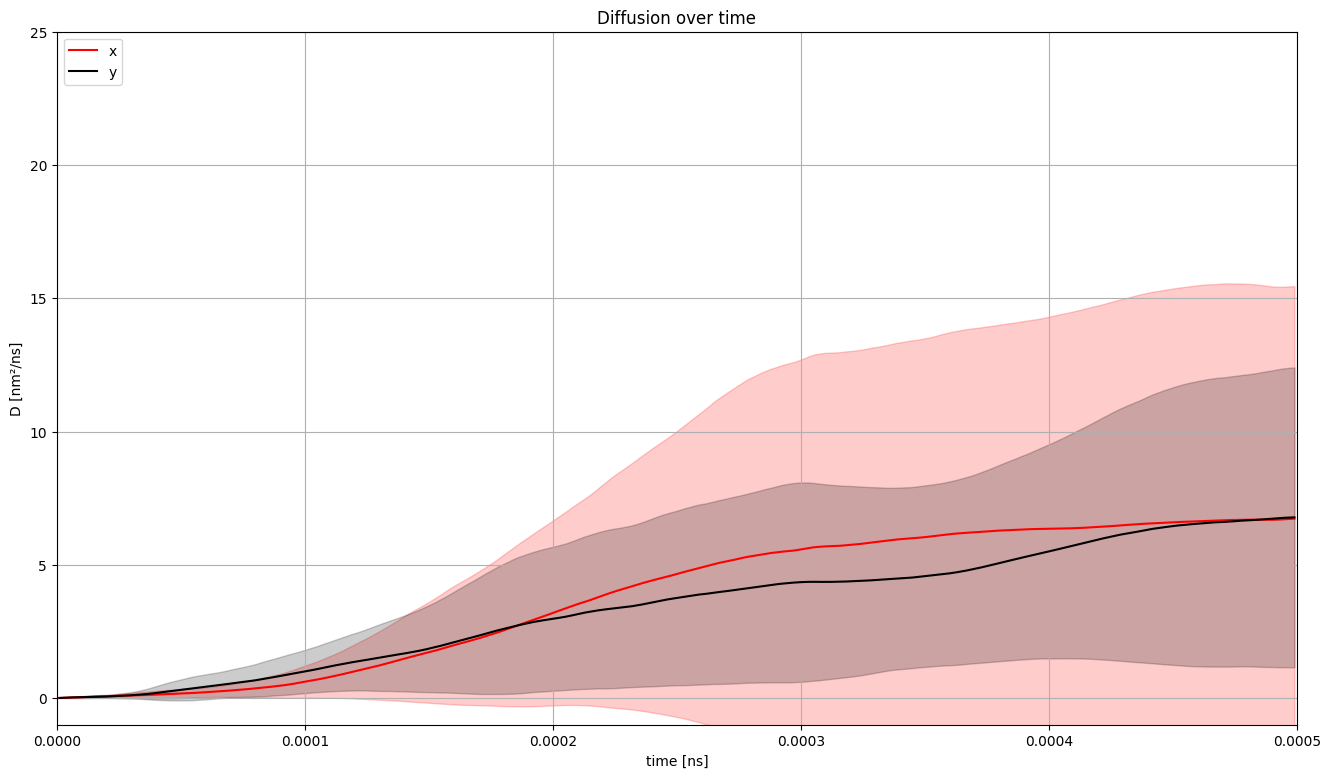

In [32]:
length = 500

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(time[:length], x_mean[:length], color = colours[0], label = 'x')
ax.plot(time[:length], y_mean[:length], color = colours[1], label = 'y')

ax.fill_between(time[:length],x_mean[:length] - x_std[:length],x_mean[:length] + x_std[:length], alpha=0.2, color = colours[0])
ax.fill_between(time[:length],y_mean[:length] - y_std[:length],y_mean[:length] + y_std[:length], alpha=0.2, color = colours[1])

ax.set_xlim(0,length/1e6)
ax.set_ylim(-1,25)

ax.set_xlabel('time [ns]')
ax.set_ylabel('D [nm²/ns]')
plt.title('Diffusion over time')
plt.grid()
plt.legend(loc='upper left')
plt.show()

In [21]:
Gamma = simL.kB*simL.temp/(np.mean(d_r, axis=0)/avogadro)
Gamma.shape

(2, 10000001)

In [22]:
#g_x_mean = np.mean(Gamma[:,0], axis=0)
#g_y_mean = np.mean(Gamma[:,1], axis=0)

#g_x_std = np.std(Gamma[:,0], axis=0)
#g_y_std = np.std(Gamma[:,1], axis=0)

colours = ['r','k']

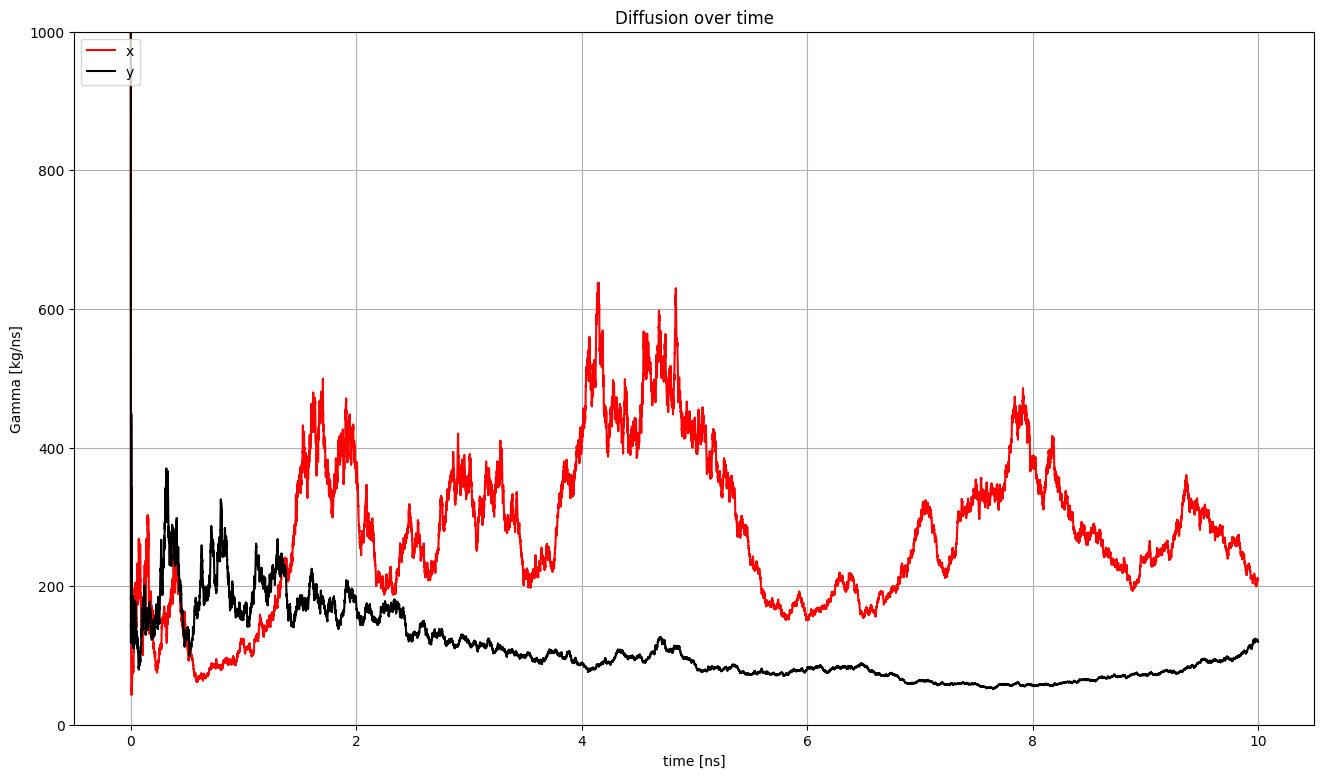

In [34]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(time,Gamma[0], color = colours[0], label = 'x')
ax.plot(time,Gamma[1], color = colours[1], label = 'y')

#ax.fill_between(time,g_x_mean - g_x_std,g_x_mean + g_x_std, alpha=0.2, color = colours[0])
#ax.fill_between(time,g_y_mean - g_y_std,g_y_mean + g_y_std, alpha=0.2, color = colours[1])

ax.set_ylim(0,1000)
ax.set_xlabel('time [ns]')

ax.set_ylabel('Gamma [kg/ns]')
plt.title('Diffusion over time')
plt.grid()
plt.legend(loc='upper left')
plt.show()